# House Prices Competition - Model Improvement

Before trying to move onto Kaggle more serious competitions, I wanted to make a model that performed well in the House Prices competition, but I was stuck somewhere in the middle of the leaderbord, so I tried different stuff to get improvements (and I got, but not dramatic ones) before this notebook. The things I did, in order, were:

1. Create a simple and fast pipeline that worked as follows. Categorical data missing values were filled with 'missing', and then all categorical columns were encoded with the OneHotEncode. Numerical data missing values were filled with the median and then all numerical columns normalized.

2. I tried to make custom label with an order that represented better the value of each label, e.g.: Good Quality -> 5, Bad Quality -> 2. But it did not improve the model.

3. Change the Random Forest for a LightGBM model. This was a great improvement both in training speed and accuracy.

4. Use grid search to optimize the parameters of the model. It improved the model a bit.

So now, at this point, let's try something new to try to improve the performance. There are two main points I want to adress. First, remove outliers from the data, in case I find. Second, make a smarter inference of missing values, taking into account other columns, and starting with the most important variables for the model.

So let's get the hands dirty!

## Step 1 - First Model

In [1]:
from imports import *

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
types = {'MSZoning': 'object'}

df_raw = pd.read_csv('train.csv', dtype=types)
df_raw.drop('Id', axis=1, inplace=True)

# This icolumn is in reality a label
df_raw.MSZoning.astype('object')

dep_var = 'SalePrice'

In [3]:
num_vars = list(df_raw.columns[df_raw.dtypes != 'object'])
cat_vars = list(df_raw.columns[df_raw.dtypes == 'object'])

num_vars.remove(dep_var)

In [4]:
num_with_missing = list(df_raw.loc[:, num_vars].columns[
                            df_raw.loc[:, num_vars].isnull().sum() > 0
                        ])

### Pipeline building

In [5]:
X = df_raw.drop(dep_var, axis=1, inplace=False)
y = np.log(df_raw[dep_var])

is_missing_cols = []
for col in num_with_missing:
    X[col+'_missing'] = X[col].isnull()
    is_missing_cols.append(col+'_missing')

In [6]:
# Custom dictionaries for our categorical labelizer

lab_dict1 = {'Ex': 6, 'Gd': 5, 'TA': 4,
             'Fa': 3, 'Po': 2, 'NA': 1}
lab_dict2 = {'Y': 2, 'N': 1}
lab_dict3 = {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5,
             'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1}
lab_dict4 = {'Pave': 2,'Grvl': 1}
lab_dict5 = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1}
lab_dict6 = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1}

custom_dicts = [lab_dict1, lab_dict2, lab_dict3,
                lab_dict4, lab_dict5, lab_dict6]

labelizer = LabelValueTransformer(custom_dicts=custom_dicts)

In [7]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('labelizer', labelizer)     # My transformer, on imports.py
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars),
        ('mis', 'passthrough', is_missing_cols)
    ])

first_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', lgb.LGBMRegressor())
                                ])

### Cross-validation

In [8]:
scores = -1 * cross_val_score(first_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_squared_error')

scores = np.sqrt(scores)

print("Logarithmic mean squared error scores:\n", scores)
print()
print("The mean of the scores is:\n", scores.mean())

Logarithmic mean squared error scores:
 [0.12231485 0.14588622 0.14176594 0.11883424 0.13670503]

The mean of the scores is:
 0.13310125435684234


### Grid Search

In [9]:
param_grid = { 
    'model__num_iterations': [250, 300, 350],
    'model__max_bin': [350, 400, 450],
    'model__max_depth': [4, 5, 6],
    'model__num_leaves' : [8, 10, 12],
}

CV = GridSearchCV(first_pipeline, param_grid, cv=5, n_jobs=4, verbose=10)
                  
CV.fit(X, y)  
print(CV.best_params_)    
print(CV.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   36.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   42.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   48.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   54.7s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  1.3min
[Parallel(

{'model__max_bin': 350, 'model__max_depth': 6, 'model__num_iterations': 300, 'model__num_leaves': 8}
0.8941202316124754


In [10]:
parameters = {'max_bin': 350,
              'max_depth': 6,
              'num_iterations': 300,
              'num_leaves': 8}

best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', lgb.LGBMRegressor(**parameters))
                                ])

scores = -1 * cross_val_score(best_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_squared_error')

scores = np.sqrt(scores)

print("Logarithmic mean squared error scores:\n", scores)
print()
print("The mean of the scores is:\n", scores.mean())

Logarithmic mean squared error scores:
 [0.11506908 0.13671696 0.13596206 0.12071308 0.13410675]

The mean of the scores is:
 0.12851358573839866


### Features importance

In [11]:
# Get features importances

best_pipeline.fit(X, y)
best_model = best_pipeline[1]
importance = best_model.feature_importances_

In [12]:
feature_imp = pd.DataFrame(sorted(zip(importance, X.columns)), columns=['Value', 'Feature'])

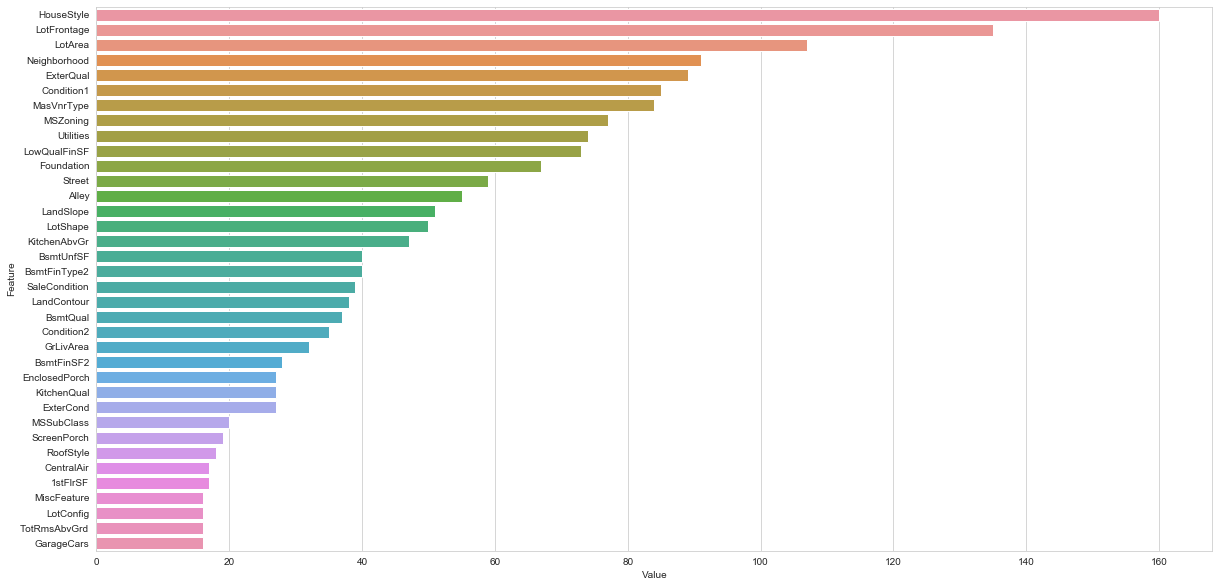

In [13]:
plt.figure(figsize=(20, 10))
sns.barplot(x='Value',
            y='Feature',
            data=feature_imp[feature_imp.Value > 15].
                    sort_values(by='Value', ascending=False)
           
           )

plt.show()

## Step 2 - Data Cleaning

### Outliers

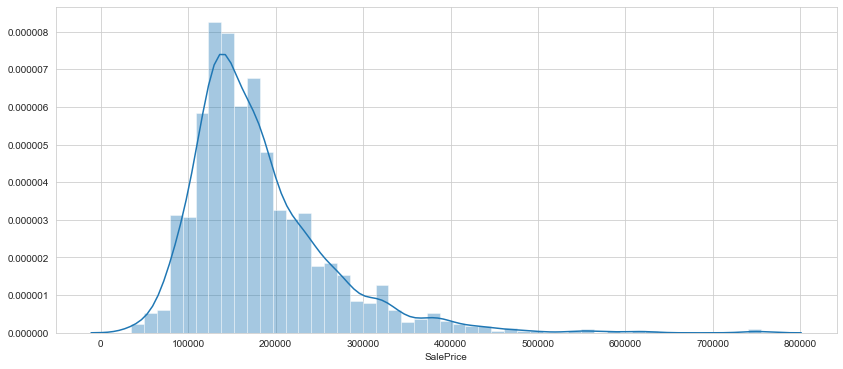

In [14]:
plt.figure(figsize=(14,6))
sns.distplot(a=df_raw.SalePrice)
plt.show()

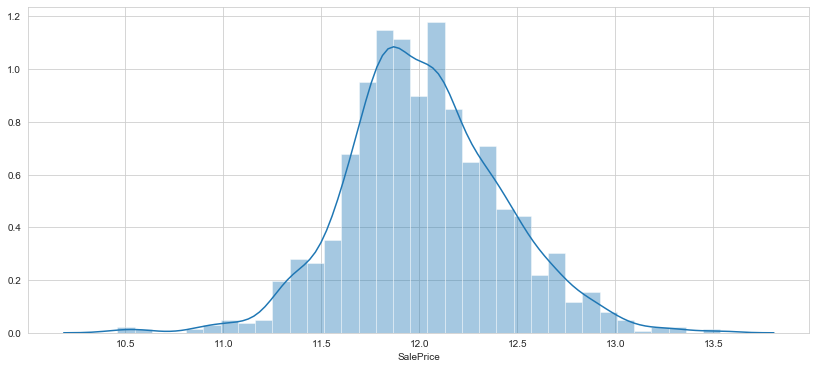

In [15]:
plt.figure(figsize=(14,6))
sns.distplot(a=np.log(df_raw.SalePrice))
plt.show()

It looks like the SalePrice follows aproximately a lognormal distribution and that there are no outliers, but let's compute the z-scores, maybe we find 1 or 2 candidates.

In [16]:
scores = pd.DataFrame(df_raw.SalePrice.copy())
scores['z_score'] = zscore(np.log(df_raw.SalePrice))
scores[scores.z_score > 3] #Usually the threshold is 3.5

,SalePrice,z_score
440,555000,3.011839
691,755000,3.782532
803,582933,3.134810
898,611657,3.255264
1046,556581,3.018962
1169,625000,3.309307
1182,745000,3.749141


The z-scores are not that high, but maybe there are other points with strange behaviours.

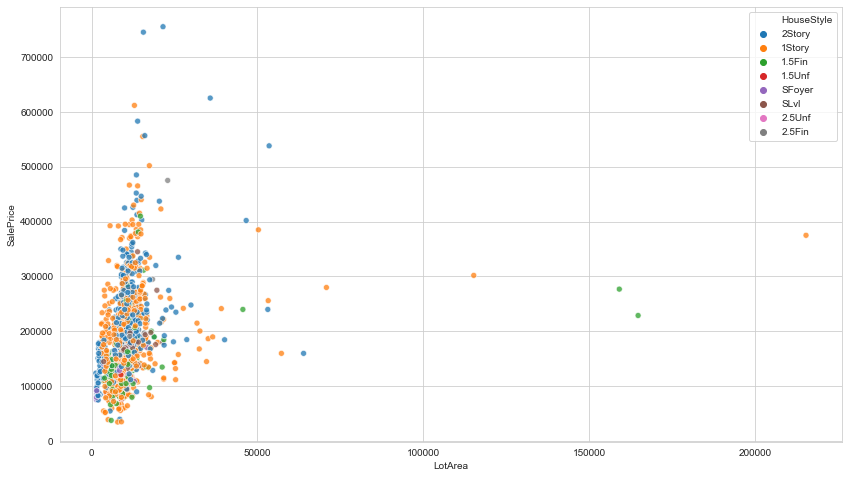

In [17]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='LotArea' , y='SalePrice', hue='HouseStyle', data=df_raw, alpha=0.75)
plt.show()

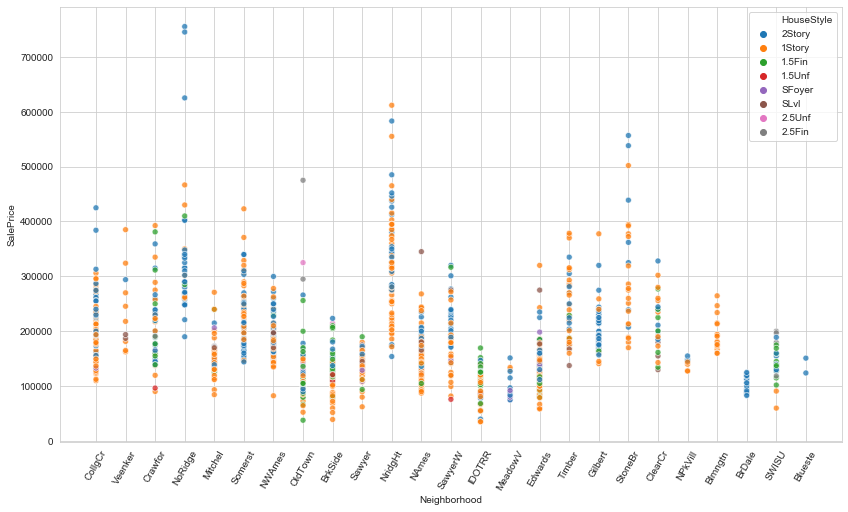

In [18]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='Neighborhood' , y='SalePrice', hue='HouseStyle', data=df_raw, alpha=0.75)
plt.xticks(rotation=60)
plt.show()

In the last figure we could observe that the two points with z-score > 3.5 are also quite distant from the mean of their neighbourhood, so let's drop them. Let's study also the distribution of the LotArea, which looks kinda weird.

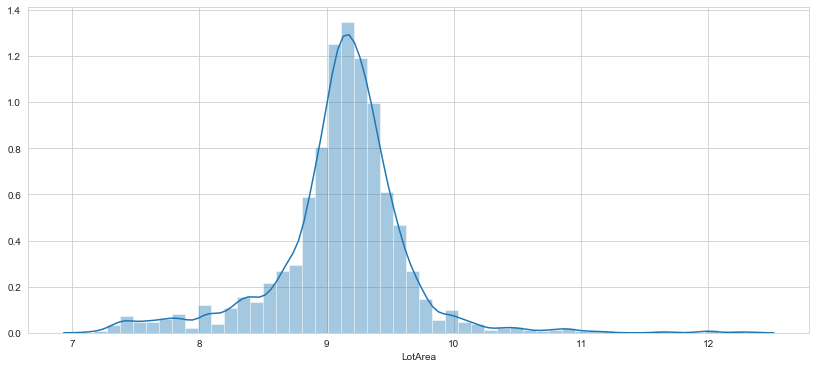

In [19]:
plt.figure(figsize=(14,6))
sns.distplot(a=np.log(df_raw.LotArea))
plt.show()

In [20]:
scores = pd.DataFrame(df_raw.LotArea.copy())
scores['z_score'] = zscore(np.log(df_raw.LotArea))
scores[scores.z_score > 3.5]

,LotArea,z_score
249,159000,5.540272
313,215245,6.125793
335,164660,5.607894
451,70761,3.975142
706,115149,4.916465
1298,63887,3.777582
1396,57200,3.563841


The distribution of the LotArea behaves as lognormal around the mean, but is a bit right-skewed. The points with area bigger than 100000 have very big z-scores, and we will also remove them.

The second most important feature for the model is the LotFrontage, which is the linear feet of street connected to property. Let's see if we can identify outliers, and also take a fast insight into the Foundation variable.

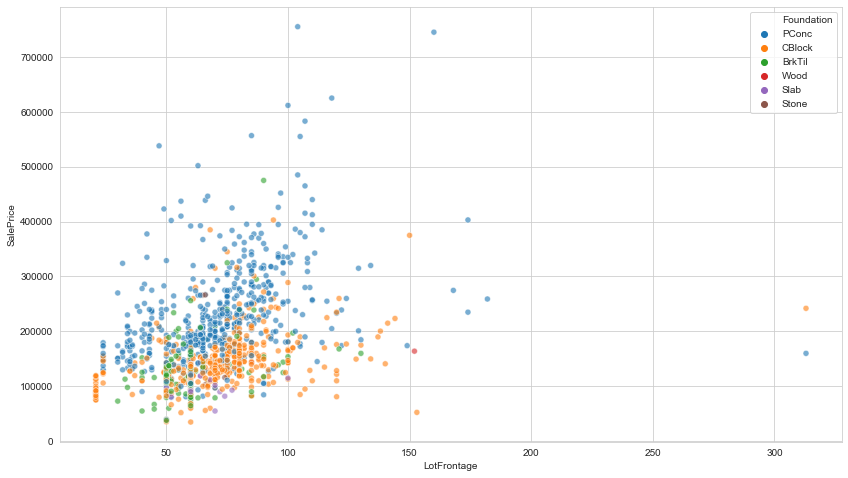

In [21]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='LotFrontage' , y='SalePrice', hue='Foundation', data=df_raw, alpha=0.6)
plt.show()

In [22]:
# Remove outliers

df = df_raw[df_raw.SalePrice < 700000].copy()
df = df[df.LotArea < 100000]
df = df[df.LotFrontage < 200]
df = df.reset_index(drop=True)

This were the main numerical variables. The rest are categorical. So let's start with the data pre-processing.

### Missing values

Let's start by finding which of the top features for our model have missing values.

In [23]:
top_features = list(feature_imp[feature_imp.Value > 10].Feature)
df[top_features].isnull().sum()[ df[top_features].isnull().sum() > 0] / df.shape[0]

BsmtExposure    0.026756
GarageYrBlt     0.061873
GarageFinish    0.061873
MiscFeature     0.967391
BsmtQual        0.025920
BsmtFinType2    0.026756
Alley           0.928094
MasVnrType      0.005017
dtype: float64

The objective of this part was to better impute the missing values if important features, but we got to a dead end, because fot the majority of them abscense of values means abscense of the specification, so the only we can do is to improve the quality of our labelling in our custom labeler. The upgraded columns are:
    
- Alley
- BsmtExposure
- Fence

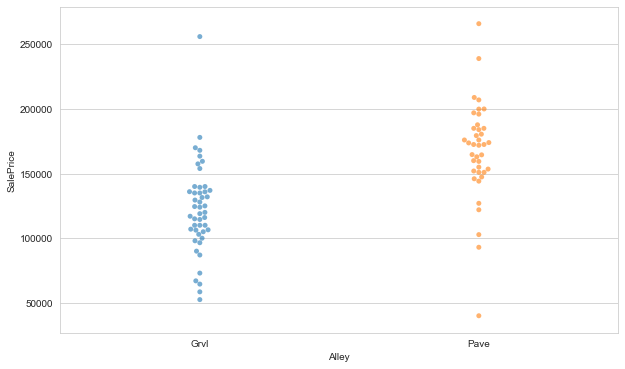

In [24]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='Alley' , y='SalePrice', data=df, alpha=0.6)
plt.show()

Alley should be labeled with 2 for Pave, 1 for Grvl and 0 for NA.

The only conditions in which we could work a bit more are MasVnrArea and MasVnrType. They both lack values for the same rows, which indicates some consistency on the labeling, but on the description of our values no masonry is indicated with a MasVnrType = No, which might mean that simply they didn't get information about the masonry, not abscense of the masonry. But let's explore data a bit.

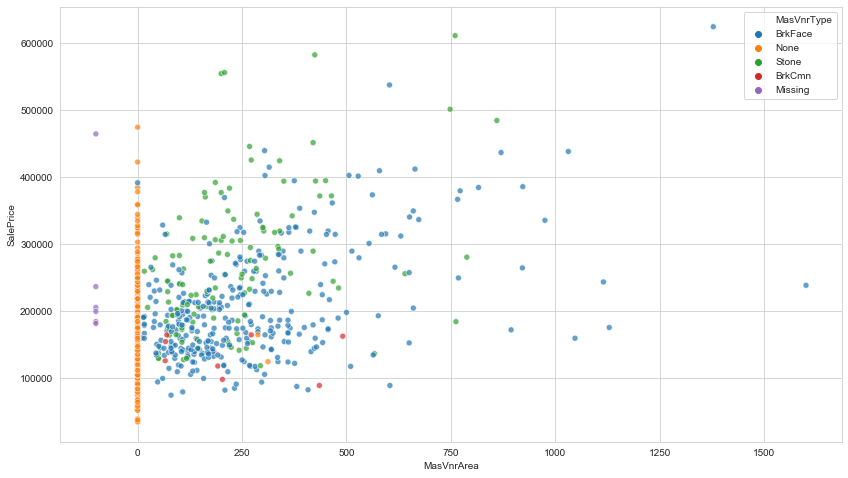

In [25]:
MasVnrArea = df.MasVnrArea.fillna(-100, inplace=False)
MasVnrType = df.MasVnrType.fillna('Missing', inplace=False)

plt.figure(figsize=(14,8))
sns.scatterplot(x=MasVnrArea, y='SalePrice', hue=MasVnrType, data=df, alpha=0.7)
plt.show()

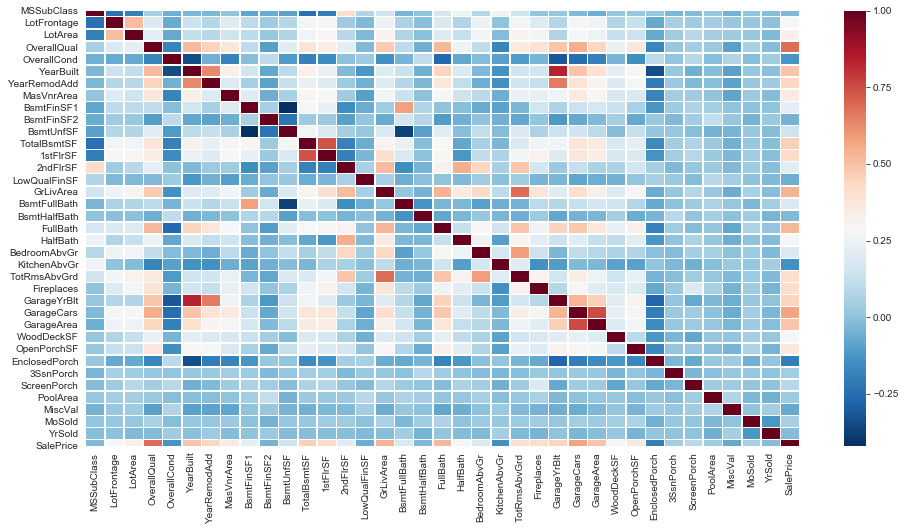

In [26]:
corr = df.corr(method='kendall')
plt.figure(figsize=(16, 8))
sns.heatmap( corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='RdBu_r',
            linewidth=0.5)
plt.show()

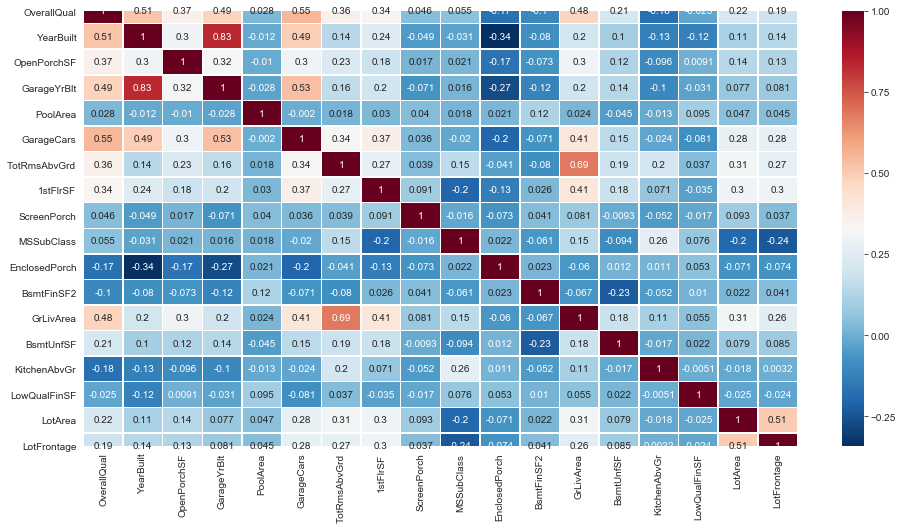

In [27]:
corr = df[top_features].corr(method='kendall')
plt.figure(figsize=(16, 8))
sns.heatmap( corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
plt.show()

As we can see in the the correlation matrix, MasVnrArea is highly related with OverallQual, so let's take a look at it to see if we can make some inferences about those missing values.

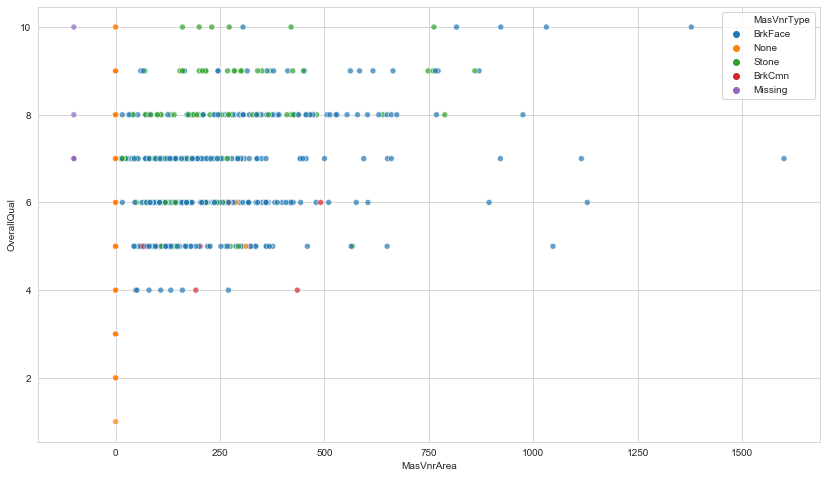

In [28]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=MasVnrArea, y='OverallQual', hue=MasVnrType, data=df, alpha=0.7)
plt.show()

The houses without MasVnrArea specification have a good quality, so the method we used from the beggining of imputing missing values with the median of the columns should work well enough.

### Year Sold

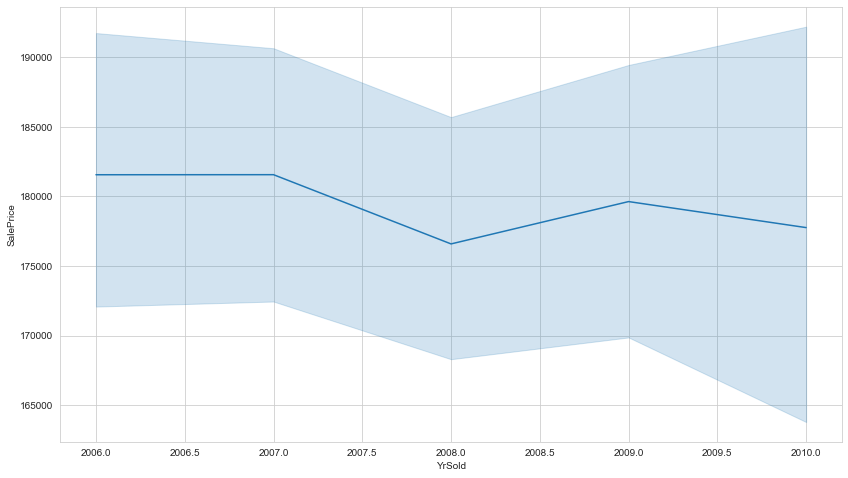

In [29]:
plt.figure(figsize=(14,8))
sns.lineplot(x='YrSold', y='SalePrice', data=df)
plt.show()

The 2007 crisis affected the house prices, but less than of what one could imagine. Also the variance increased from 2008. The data of the test set is also contained in the same time period, so no special means are needed to deal with time data.

### Hierarchical Clustering

In [30]:
corr = pd.DataFrame(best_pipeline[0].transform(X), columns=X.columns).corr(method='spearman')

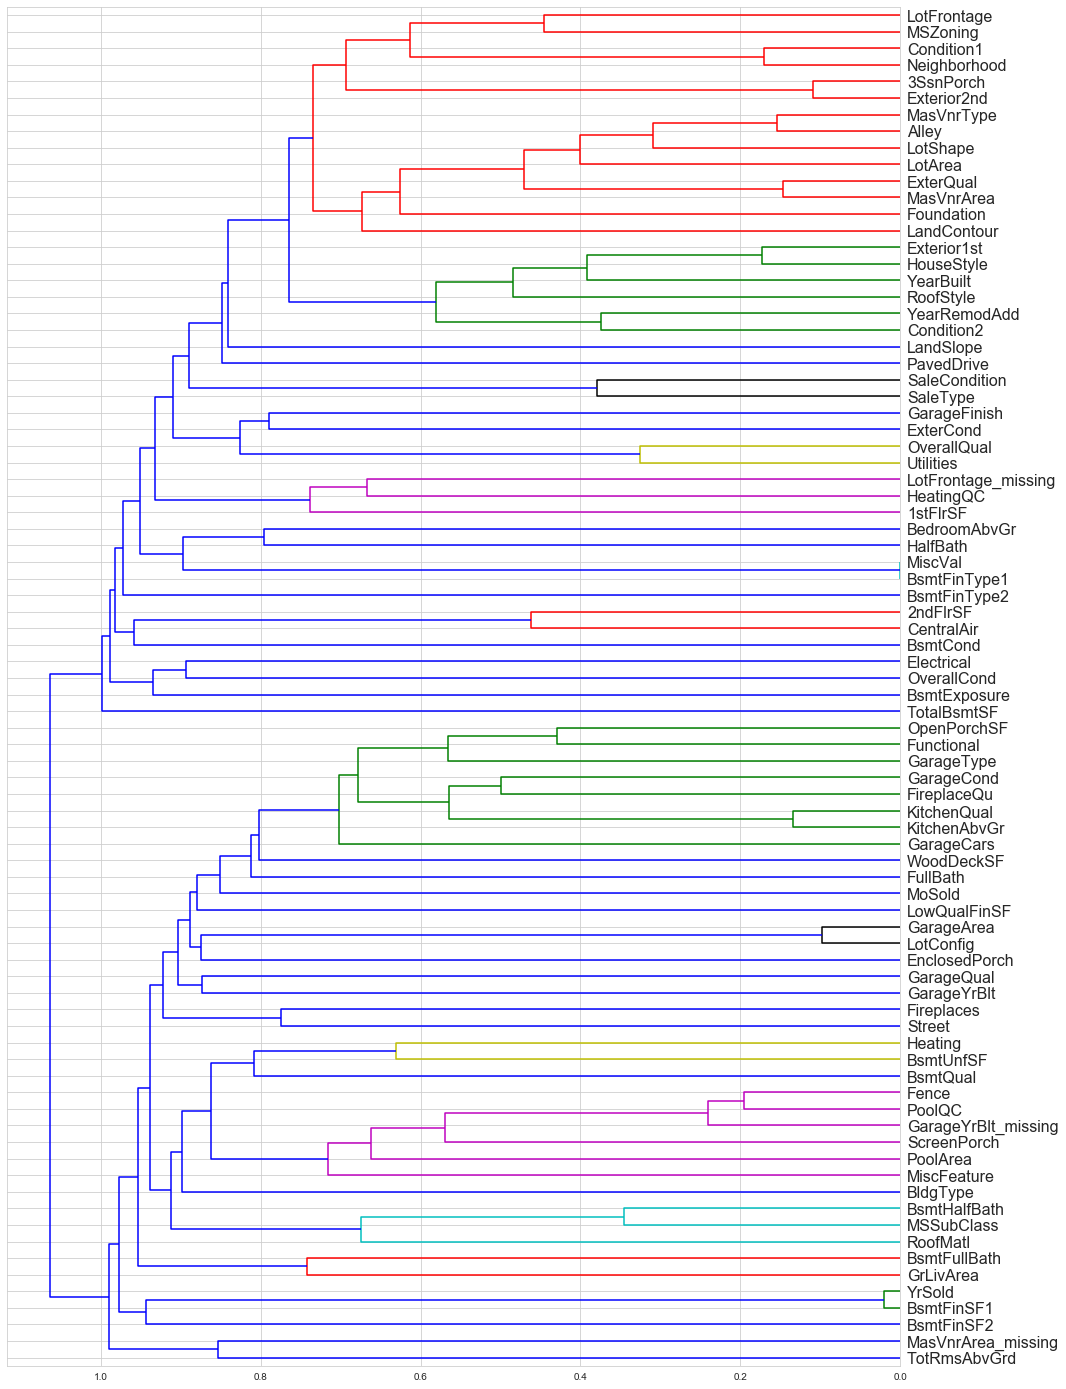

In [31]:
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
plt.figure(figsize=(16, 25))
dendogram = hc.dendrogram(z, labels=X.columns, orientation='left', leaf_font_size=16)
plt.show()

As we can see in the dendogram there are no strong relationship between variables, which indicates that is a good idea to keep them all. But what we can also see is two strange relationships that we could inspect more in detail: the relationship between MiscVal and BsmtFinType1, and the relationship between YrSold and BsmtFinSF1.

## Step 3 - Feature Selection

Here we'll try to find a better subset of features for our model. The first step will be to see how important is each feature for our prediction. To do this, we'll start by, for each feature, calculating the prediction power lost by the model when predicting without that feature (note that a negative value would mean an improvement in the prediction).

In [32]:
scores = cross_val_score(best_pipeline, X, y,
                              cv=5,
                              scoring='r2',
                              n_jobs=1)
model_r2 = scores.mean()

In [33]:
%%time
pred_power = {}
for col in X.columns:
    shuffled = X[col].copy()
    new_X = X.copy()
    
    np.random.shuffle(shuffled)
    new_X[col] = shuffled
    
    score = cross_val_score(best_pipeline, new_X, y,
                              cv=5,
                              scoring='r2',
                              n_jobs=1
                           ).mean()
    
    pred_power[col] = model_r2 - score

Wall time: 7min 45s


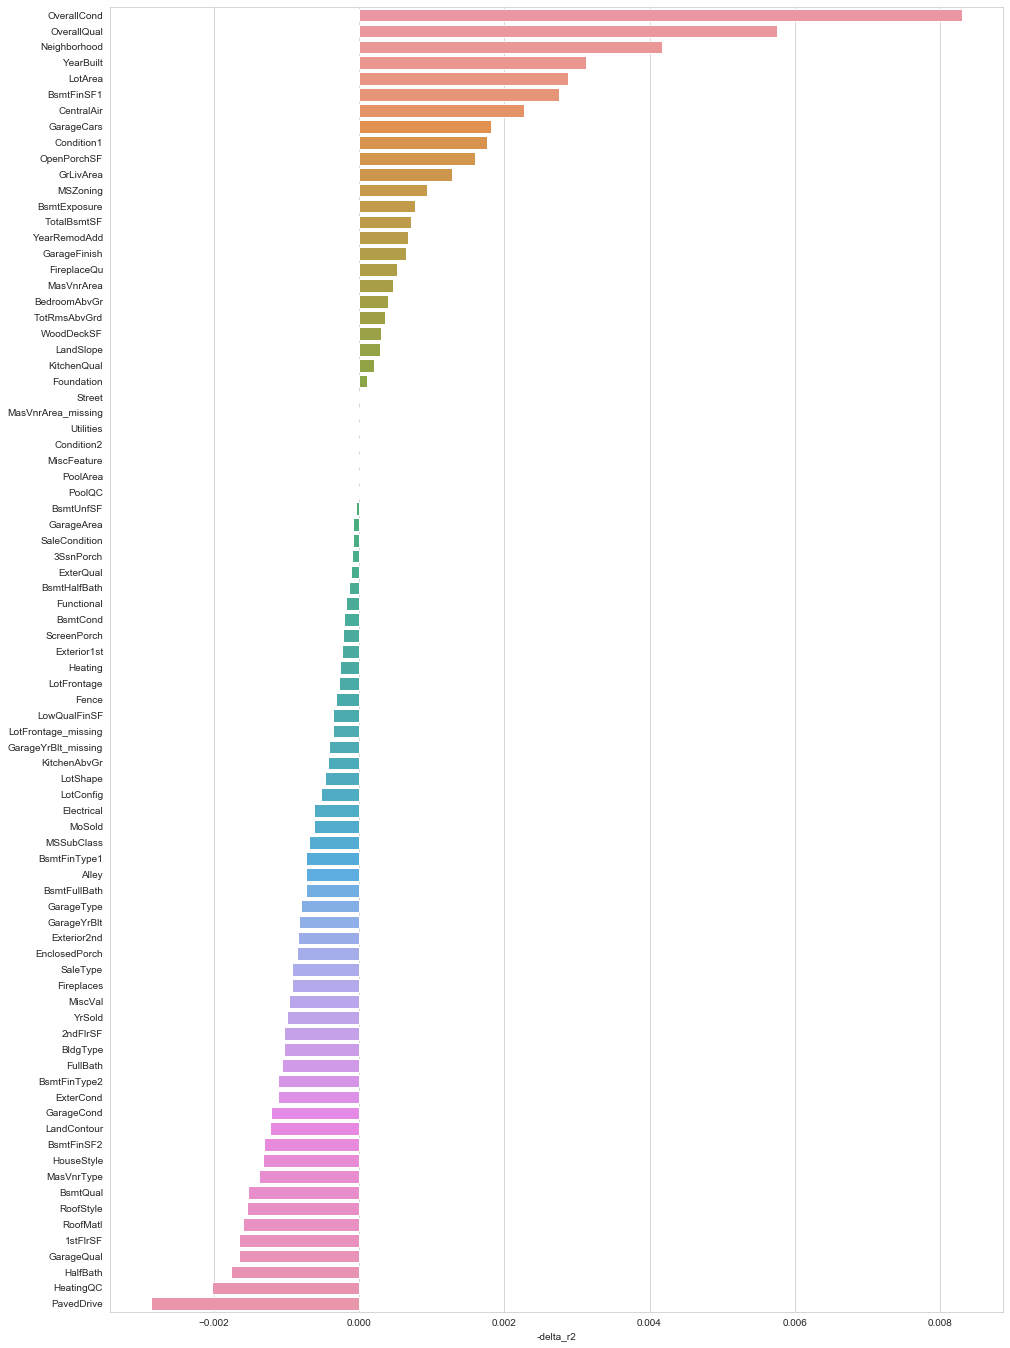

In [34]:
to_plot = pd.DataFrame.from_dict(pred_power,
                                 orient='index',
                                 columns=['-delta_r2']
                                ).sort_values(by='-delta_r2', ascending=False)

plt.figure(figsize=(16, 24))
sns.barplot(
    y=to_plot.index,
    x=to_plot['-delta_r2'],
)
plt.show()

As we can see, our model gains in performance when its most important feature for prediction, HouseStyle, is removed. This is likely due to the fact that the information given by that feature is very important but can be obtained through other features, so we'll remove it.

In [35]:
cols_to_drop = ['HouseStyle']
X[cols_to_drop].dtypes

HouseStyle    object
dtype: object

In [36]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_vars),
        ('cat', categorical_transformer, [col for col in cat_vars if col not in cols_to_drop]),
        ('mis', 'passthrough', is_missing_cols),
        ('drp', 'drop', cols_to_drop)
    ])

best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', lgb.LGBMRegressor(**parameters))
                                ])

## Step 4 - Final Model and Submission

In [37]:
# As we deleted some rows we should re-do this

num_vars = list(df_raw.columns[df_raw.dtypes != 'object'])
cat_vars = list(df_raw.columns[df_raw.dtypes == 'object'])

num_vars.remove(dep_var)

num_with_missing = list(df_raw.loc[:, num_vars].columns[
                            df_raw.loc[:, num_vars].isnull().sum() > 0
                        ])

In [38]:
X_test = pd.read_csv('test.csv', dtype=types)
X_test.drop('Id', axis=1, inplace=True)

for col in num_with_missing:
    X_test[col+'_missing'] = X_test[col].isnull()

In [39]:
best_pipeline.fit(X, y)

prediction = pd.DataFrame(np.exp(best_pipeline.predict(X_test)))

prediction = prediction.reset_index()
prediction.columns = ['Id', 'SalePrice']
prediction.Id += 1461

In [40]:
prediction.to_csv('prediction.csv', index=False)

The score on Kaggle of the prediction was: 0.12827.

Which took me to the position 1441 out of 4539. That's the top 32%!